# Sentiment Analysis on Amazon Reviews dataset 2023

In this notebook we will be doing some sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from Huggingface
3. Huggingface Pipeline

# Step 0. Read in Data and NLTK Basics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
# Read in data
Appliance_subset_df = pd.read_parquet('..\Project Main\data\Appliance_file_subset.parquet', engine='pyarrow')

In [3]:
Appliance_subset_df.head(5)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,1.0,Does not fit... Too short.,Does not fit... Too short,[],B00M0YZ7DY,B00M0YZ7DY,AFAN52Y5DDFZXZYZSWVQKVTR3YGQ,1651357957260,0,True
1,5.0,Ice is produced quickly,I love that I don't have to wait long for the ...,[],B0B96H8CG6,B0B9NCB4KS,AHEUYZB4T4ZIV42BU4EXDVUBCBYQ,1669001754651,5,True
2,5.0,Works perfectly as a replacement to Samsung fi...,Works perfectly as a replacement to Samsung fi...,[],B00E37TR5U,B0C7GKM91B,AHOWFYPLPGDPDFNQGILVACTA56UA,1476993810000,0,False
3,5.0,That the eggs fit nicely,Very nice the perfect size,[],B08F32WWFJ,B08F32WWFJ,AFPV53CFHPWDHMG3BUFUXJZCND2A,1611080325978,0,True
4,5.0,Perfect,Perfect replacement for my AprileAir init,[],B00NVPTWXM,B00NVPTWXM,AHIYTHTB26373L5GOSKAXUH2WPMQ,1680973305570,0,True


In [4]:
print(Appliance_subset_df.shape)

(50000, 10)


In [5]:
Appliance_subset_df['rating'].value_counts().sort_index()

rating
1.0     5995
2.0     1881
3.0     2406
4.0     4890
5.0    34828
Name: count, dtype: int64

## Quick EDA

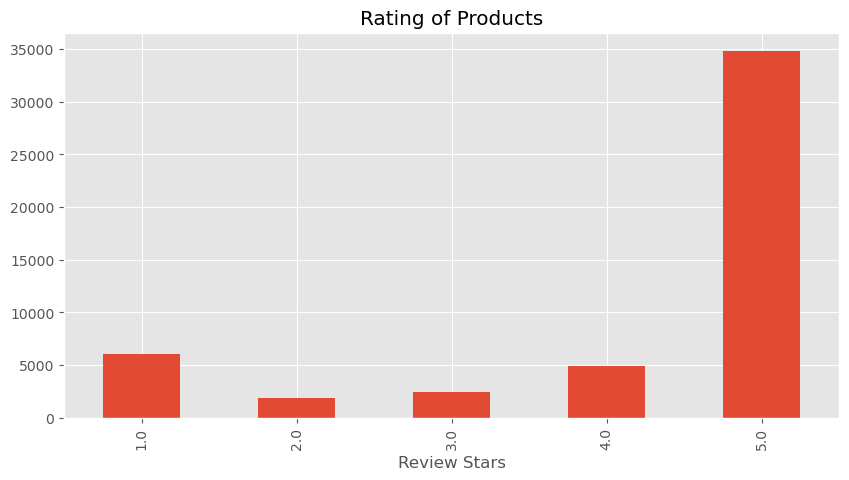

In [6]:
rating = Appliance_subset_df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Rating of Products',
          figsize=(10, 5))
rating.set_xlabel('Review Stars')
plt.show()

## NLTK

In [7]:
example = Appliance_subset_df['text'][1989]
print(example)

Arrived in a reasonable time frame and was exactly as described. Worked great on my Whirlpool washer.


In [8]:
tokens = nltk.word_tokenize(example)
tokens[:]

['Arrived',
 'in',
 'a',
 'reasonable',
 'time',
 'frame',
 'and',
 'was',
 'exactly',
 'as',
 'described',
 '.',
 'Worked',
 'great',
 'on',
 'my',
 'Whirlpool',
 'washer',
 '.']

In [9]:
#part of speech tagging values
tagged = nltk.pos_tag(tokens)
tagged[:]

[('Arrived', 'VBN'),
 ('in', 'IN'),
 ('a', 'DT'),
 ('reasonable', 'JJ'),
 ('time', 'NN'),
 ('frame', 'NN'),
 ('and', 'CC'),
 ('was', 'VBD'),
 ('exactly', 'RB'),
 ('as', 'IN'),
 ('described', 'VBN'),
 ('.', '.'),
 ('Worked', 'VBN'),
 ('great', 'JJ'),
 ('on', 'IN'),
 ('my', 'PRP$'),
 ('Whirlpool', 'NNP'),
 ('washer', 'NN'),
 ('.', '.')]

In [10]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()
#prettyprint

(S
  Arrived/VBN
  in/IN
  a/DT
  reasonable/JJ
  time/NN
  frame/NN
  and/CC
  was/VBD
  exactly/RB
  as/IN
  described/VBN
  ./.
  Worked/VBN
  great/JJ
  on/IN
  my/PRP$
  Whirlpool/NNP
  washer/NN
  ./.)


# Step 1. VADER Sentiment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [11]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [12]:
sia

In [13]:
sia.polarity_scores("It was a complete waste of time")

{'neg': 0.359, 'neu': 0.641, 'pos': 0.0, 'compound': -0.4215}

In [14]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.785, 'pos': 0.215, 'compound': 0.6249}

In [15]:
sia.polarity_scores("Fits perfect")

{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}

In [16]:
sia.polarity_scores('Easy Replacement Parts for Appliances at a Reduced Price and fits perfect')

{'neg': 0.0, 'neu': 0.577, 'pos': 0.423, 'compound': 0.765}

In [17]:
sia.polarity_scores('Easy Replacement Parts for Appliances at a Reduced Price and fits perfect...')

{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.4404}

In [18]:
# Run the polarity score on the entire dataset
results = {}
for i, row in tqdm(Appliance_subset_df.iterrows(), total=len(Appliance_subset_df)):
    opinion = row['text']
    id = row['user_id']
    results[id] = sia.polarity_scores(opinion)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [19]:
results

{'AFAN52Y5DDFZXZYZSWVQKVTR3YGQ': {'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0,
  'compound': 0.0},
 'AHEUYZB4T4ZIV42BU4EXDVUBCBYQ': {'neg': 0.0,
  'neu': 0.688,
  'pos': 0.312,
  'compound': 0.9422},
 'AHOWFYPLPGDPDFNQGILVACTA56UA': {'neg': 0.0,
  'neu': 0.613,
  'pos': 0.387,
  'compound': 0.787},
 'AFPV53CFHPWDHMG3BUFUXJZCND2A': {'neg': 0.0,
  'neu': 0.298,
  'pos': 0.702,
  'compound': 0.7939},
 'AHIYTHTB26373L5GOSKAXUH2WPMQ': {'neg': 0.0,
  'neu': 0.575,
  'pos': 0.425,
  'compound': 0.5719},
 'AE4F2A5RVFXI7VV2OX6NBQ5XUSLQ': {'neg': 0.0,
  'neu': 0.718,
  'pos': 0.282,
  'compound': 0.9342},
 'AETNTZE3WQD46BIJGRXJCJ4SQWBQ': {'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0,
  'compound': 0.0},
 'AESNEEPLCVPKOGPR4P4GKHQ3Z4JQ': {'neg': 0.0,
  'neu': 0.848,
  'pos': 0.152,
  'compound': 0.3612},
 'AEKDHTQPO2R2W2TKPAVYTGEE4XKQ': {'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0,
  'compound': 0.0},
 'AGJVMCZA6OMT3JJT6HHCHGXWAVCA': {'neg': 0.0,
  'neu': 0.295,
  'pos': 0.705,
  'compound': 0.3382},
 'AFAD5KA7XL

In [20]:
vaders = pd.DataFrame(results).T
vaders.head()

,neg,neu,pos,compound
AFAN52Y5DDFZXZYZSWVQKVTR3YGQ,0.0,1.000,0.000,0.0000
AHEUYZB4T4ZIV42BU4EXDVUBCBYQ,0.0,0.688,0.312,0.9422
AHOWFYPLPGDPDFNQGILVACTA56UA,0.0,0.613,0.387,0.7870
AFPV53CFHPWDHMG3BUFUXJZCND2A,0.0,0.298,0.702,0.7939
AHIYTHTB26373L5GOSKAXUH2WPMQ,0.0,0.575,0.425,0.5719


In [21]:
vaders.index.name = 'user_id'
vaders.head()

,neg,neu,pos,compound
user_id,,,,
AFAN52Y5DDFZXZYZSWVQKVTR3YGQ,0.0,1.000,0.000,0.0000
AHEUYZB4T4ZIV42BU4EXDVUBCBYQ,0.0,0.688,0.312,0.9422
AHOWFYPLPGDPDFNQGILVACTA56UA,0.0,0.613,0.387,0.7870
AFPV53CFHPWDHMG3BUFUXJZCND2A,0.0,0.298,0.702,0.7939
AHIYTHTB26373L5GOSKAXUH2WPMQ,0.0,0.575,0.425,0.5719


In [22]:
# Reset the index to turn the index into a column
vaders = vaders.reset_index()
vaders.head()


,user_id,neg,neu,pos,compound
0,AFAN52Y5DDFZXZYZSWVQKVTR3YGQ,0.0,1.000,0.000,0.0000
1,AHEUYZB4T4ZIV42BU4EXDVUBCBYQ,0.0,0.688,0.312,0.9422
2,AHOWFYPLPGDPDFNQGILVACTA56UA,0.0,0.613,0.387,0.7870
3,AFPV53CFHPWDHMG3BUFUXJZCND2A,0.0,0.298,0.702,0.7939
4,AHIYTHTB26373L5GOSKAXUH2WPMQ,0.0,0.575,0.425,0.5719


In [23]:
vaders = vaders.merge(Appliance_subset_df, how='inner')

In [24]:
# Now we have sentiment score and metadata
vaders.head()

,user_id,neg,neu,pos,compound,rating,title,text,images,asin,parent_asin,timestamp,helpful_vote,verified_purchase
0,AFAN52Y5DDFZXZYZSWVQKVTR3YGQ,0.0,1.000,0.000,0.0000,1.0,Does not fit... Too short.,Does not fit... Too short,[],B00M0YZ7DY,B00M0YZ7DY,1651357957260,0,True
1,AHEUYZB4T4ZIV42BU4EXDVUBCBYQ,0.0,0.688,0.312,0.9422,5.0,Ice is produced quickly,I love that I don't have to wait long for the ...,[],B0B96H8CG6,B0B9NCB4KS,1669001754651,5,True
2,AHOWFYPLPGDPDFNQGILVACTA56UA,0.0,0.613,0.387,0.7870,5.0,Works perfectly as a replacement to Samsung fi...,Works perfectly as a replacement to Samsung fi...,[],B00E37TR5U,B0C7GKM91B,1476993810000,0,False
3,AFPV53CFHPWDHMG3BUFUXJZCND2A,0.0,0.298,0.702,0.7939,5.0,That the eggs fit nicely,Very nice the perfect size,[],B08F32WWFJ,B08F32WWFJ,1611080325978,0,True
4,AHIYTHTB26373L5GOSKAXUH2WPMQ,0.0,0.575,0.425,0.5719,5.0,Perfect,Perfect replacement for my AprileAir init,[],B00NVPTWXM,B00NVPTWXM,1680973305570,0,True


## Plot VADER results

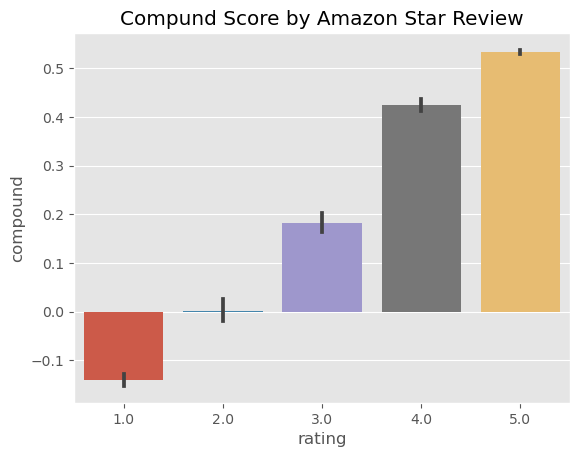

In [25]:
ax = sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

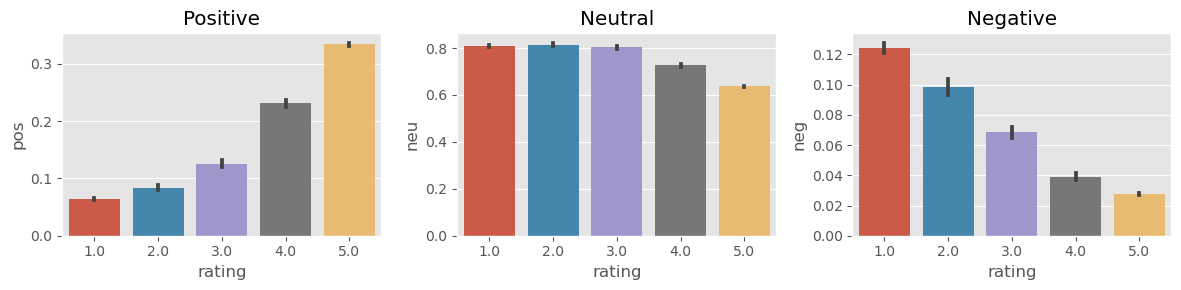

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [27]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [28]:
#pull in a model provided by hugging face pre-trained on a large twitter dataset 
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

c:\Users\gisi_\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [29]:
# Remembering VADER results on example
print(example)
sia.polarity_scores(example)

Arrived in a reasonable time frame and was exactly as described. Worked great on my Whirlpool washer.


{'neg': 0.0, 'neu': 0.785, 'pos': 0.215, 'compound': 0.6249}

In [30]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0028243833, 'roberta_neu': 0.04714478, 'roberta_pos': 0.95003086}


In [31]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [32]:
df = Appliance_subset_df.sample(5000)

In [33]:
df.head(2)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
15746,5.0,Fit perfect on older range hood,Good quality for the $$,[],B00VO6K7F2,B00VO6K7F2,AHP7ZMF7PQWKJWMCUIT64QLEXCNQ,1636623310325,0,True
18408,2.0,Failed for the second time.,One of the thermal switch failed &#34;TWICE&#3...,[],B010U47TE0,B010U47TE0,AE45HFL6PFSQ4JR6XF6MNBVDNHDQ,1503024167425,0,True


In [34]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        
        
        text = row['text']
        id = row['user_id']
        vader_result = sia.polarity_scores(text)
        
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[id] = both
    except RuntimeError:
        print(f'Broke for id {id}')

  0%|          | 0/5000 [00:00<?, ?it/s]

Broke for id AGQIBL5Q7SQBXXG775ORGNCL25LA
Broke for id AHAFRI7B56RFEAQZC4DASE6EERCQ
Broke for id AGUGHISXT7SMSWY6QWFZMXNWHBUA
Broke for id AHQZKE42VGVBLNKSOEXP2QOSNVJA
Broke for id AGABT3JEO36JMIVGU6LUO6FJXSXQ
Broke for id AGBWPBAI47GYT2FE5TPY2ZV2LAKQ
Broke for id AFMQUP7Y3N52JC64JWPERJAVGG2A
Broke for id AGOSZAZKDR5U26UXMKWM2HT3ZM6Q
Broke for id AHZ6ZIOF2N2GE7S4VF3B7GU7Y4IQ
Broke for id AGPLS2I7PQPH3U2PCJVUDLCVPYIA


In [35]:
results_df = pd.DataFrame(res).T
# results_df = results_df.reset_index().rename(columns={'index': 'Id'})


results_df.index.name = 'user_id'
results_df.head(2)

,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
user_id,,,,,,,
AHP7ZMF7PQWKJWMCUIT64QLEXCNQ,0.00,0.58,0.42,0.4404,0.018061,0.326678,0.655262
AE45HFL6PFSQ4JR6XF6MNBVDNHDQ,0.32,0.68,0.00,-0.5106,0.895101,0.099888,0.005011


In [36]:
# Reset the index to turn the index into a column
results_df = results_df.reset_index()
results_df.head()

,user_id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
0,AHP7ZMF7PQWKJWMCUIT64QLEXCNQ,0.000,0.580,0.420,0.4404,0.018061,0.326678,0.655262
1,AE45HFL6PFSQ4JR6XF6MNBVDNHDQ,0.320,0.680,0.000,-0.5106,0.895101,0.099888,0.005011
2,AHBGX36GN7DEMARELKQJIOYYXMEA,0.087,0.913,0.000,-0.6808,0.842642,0.138324,0.019034
3,AH7FSUUWGSAV3R42FSUN5LLFOT6A,0.000,1.000,0.000,0.0000,0.168133,0.727627,0.104240
4,AG6L6Y46LIQGOEHWO7KDASF5NB7A,0.030,0.871,0.098,0.7096,0.239765,0.463678,0.296557


# Step 3. Combine and compare

In [38]:
results_df = results_df.merge(Appliance_subset_df, how='inner')

In [39]:
results_df.head(2)

,user_id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,rating,title,text,images,asin,parent_asin,timestamp,helpful_vote,verified_purchase
0,AHP7ZMF7PQWKJWMCUIT64QLEXCNQ,0.00,0.58,0.42,0.4404,0.018061,0.326678,0.655262,5.0,Fit perfect on older range hood,Good quality for the $$,[],B00VO6K7F2,B00VO6K7F2,1636623310325,0,True
1,AE45HFL6PFSQ4JR6XF6MNBVDNHDQ,0.32,0.68,0.00,-0.5106,0.895101,0.099888,0.005011,2.0,Failed for the second time.,One of the thermal switch failed &#34;TWICE&#3...,[],B010U47TE0,B010U47TE0,1503024167425,0,True


In [42]:
results_df = results_df[['text', 'vader_neg', 'vader_neu', 'vader_pos', 
                         'vader_compound', 'roberta_neg', 'roberta_neu', 
                         'roberta_pos', 'rating']]

# Reset the index to replace 'user_id' with a simple integer index
results_df = results_df.reset_index(drop=True)

# Display the resulting dataframe
results_df.head()

,text,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,rating
0,Good quality for the $$,0.000,0.580,0.420,0.4404,0.018061,0.326678,0.655262,5.0
1,One of the thermal switch failed &#34;TWICE&#3...,0.320,0.680,0.000,-0.5106,0.895101,0.099888,0.005011,2.0
2,This is not what I expected This should only b...,0.087,0.913,0.000,-0.6808,0.842642,0.138324,0.019034,1.0
3,Purchase for my grandmother.,0.000,1.000,0.000,0.0000,0.168133,0.727627,0.104240,5.0
4,Thermostat didn't work. Temp range from 17-60...,0.030,0.871,0.098,0.7096,0.239765,0.463678,0.296557,1.0


In [44]:
# Select specific rows from the DataFrame based on the row indices you provided
sample_rows = results_df.loc[[0, 2, 80, 82, 289, 520], ['text', 'vader_neg', 'vader_neu', 'vader_pos', 
                                                        'vader_compound', 'roberta_neg', 'roberta_neu', 
                                                        'roberta_pos', 'rating']]

# Display the selected rows
sample_rows


,text,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,rating
0,Good quality for the $$,0.000,0.580,0.420,0.4404,0.018061,0.326678,0.655262,5.0
2,This is not what I expected This should only b...,0.087,0.913,0.000,-0.6808,0.842642,0.138324,0.019034,1.0
80,Was impressed by the quality of the replacemen...,0.037,0.881,0.082,0.6059,0.012443,0.105263,0.882294,5.0
82,"Exactly what I needed, but this is overpriced....",0.000,0.779,0.221,0.7783,0.485751,0.422568,0.091681,3.0
289,Worked great. Just as advertised. Fit exactly....,0.000,0.515,0.485,0.7650,0.004756,0.049307,0.945937,5.0
520,It was a little harder to install than we anti...,0.142,0.858,0.000,-0.6310,0.860400,0.126983,0.012616,4.0


In [40]:
results_df[['vader_neg', 'vader_neu', 'vader_pos', 
            'roberta_neg', 'roberta_neu', 'roberta_pos']] = results_df[
            ['vader_neg', 'vader_neu', 'vader_pos', 
             'roberta_neg', 'roberta_neu', 'roberta_pos']].astype(float)


In [41]:
print(results_df.dtypes)


user_id               object
vader_neg            float64
vader_neu            float64
vader_pos            float64
vader_compound       float64
roberta_neg          float64
roberta_neu          float64
roberta_pos          float64
rating               float64
title                 object
text                  object
images                object
asin                  object
parent_asin           object
timestamp              int64
helpful_vote           int64
verified_purchase       bool
dtype: object


# __